(-0.5, 511.5, 511.5, -0.5)

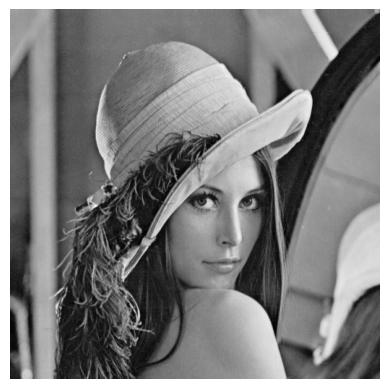

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

originalImage = cv2.imread('Lenna.png')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
plt.imshow(grayImage, cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

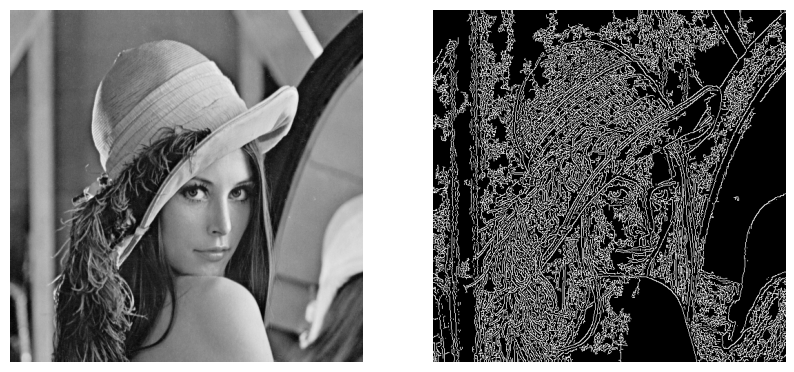

In [3]:
# Using Built-In Canny Edge Detector
global grayImage

edges_image = cv2.Canny(image=grayImage, threshold1=52, threshold2=0, L2gradient=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
plt.imshow(grayImage, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2) 
plt.imshow(edges_image, cmap='gray')
plt.axis('off')

In [26]:
# Using Canny from scratch
import cv2
import numpy as np
global grayImage

"""
Canny Edge Detector
Steps:
1- Apply Gaussian Filter to remove noise effect
2- Apply Gradient Operator(Sobel Filter) and get magnitude and orientation
3- non-maximum supperession : transform edges into thin edges by keep the local maxima only
4- Double Thresholding & Hystersis: Keep strong edges and weaks edges connected to it and remove the rest.
""" 
def cannyOperator():
    # Define Paramters
    kernelSize= (5, 5)
    sigmaValue = 400
    threshold1 = 10
    threshold2 = 100

    # First : Apply Gaussian Filter
    filteredImage = cv2.GaussianBlur(grayImage, kernelSize, sigmaX=sigmaValue) 
    # Second : Apply Gradient Operator + Double Thresholding
    edgyImage, orientation, x_edges_image, y_edges_image = gradientOperator(filteredImage)
    # Third : Apply non-maximum supperssion
    edgyImage = nonMaximumSuppression(edgyImage, orientation)
    # Fourth : Apply 1D Laplacian Operator / Edge Tracking at the direction of the edge.
    edgyImage = DoubleThresholdingAndHysteresis(edgyImage, threshold1, threshold2)

    return edgyImage

def gradientOperator(filteredImage):
    # Gradient Operator using a soble kernel as the first derivative mask.
    sobelKernel_Y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobelKernel_X = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    kernels = {
        "KernelX" : sobelKernel_X,
        "KernelY" : sobelKernel_Y
    }
    # return applyKernelForLoop(filteredImage, kernels)
    return applyKernelFT(filteredImage, kernels)

"""
Apply Kernels to the images and return the Horizontal edges, Vertical edges and filtered image
""" 
def applyKernelForLoop(image, kernels):
    pass

def applyKernelFT(image, kernels):
    height, width = image.shape  

    kernelX_padded = np.zeros((height, width), dtype=np.float32)
    kernelY_padded = np.zeros((height, width), dtype=np.float32)

    kernelX_padded[:3, :3] = kernels['KernelX']
    kernelY_padded[:3, :3] = kernels['KernelY']

    kernelX = np.fft.fft2(kernelX_padded)
    kernelY = np.fft.fft2(kernelY_padded)
    image_FT = np.fft.fft2(image)

    Gx_edges = image_FT * kernelX
    Gy_edges = image_FT * kernelY

    x_edges_image = np.fft.ifft2(Gx_edges).real
    y_edges_image = np.fft.ifft2(Gy_edges).real

    edgyImage = np.sqrt(x_edges_image ** 2 + y_edges_image ** 2)
    orientation = np.angle(image_FT) 
   

    #edgyImage = cv2.normalize(np.abs(edgyImage), None, 0, 255, cv2.NORM_MINMAX)

    return edgyImage, orientation, x_edges_image, y_edges_image


"""
This function used to give a thinner edges by check the pixel and its neighbors 
(and its neighobrs depends on the direction of the edge) and if it's the local maxima 
i will keep it, otherwise it will be set = 0
"""
def nonMaximumSuppression(magnitude, orientation):
    h, w = magnitude.shape
    suppressed = np.zeros((h, w), dtype=np.float32)
    
    # Convert angles from radians to degrees
    angle = np.rad2deg(orientation) % 180

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            q, r = 255, 255  # Neighbor pixels
            # Choose the neighbors depending on the direction of edge in this pixel.            
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = magnitude[i, j + 1] 
                r = magnitude[i, j - 1]  
            elif 22.5 <= angle[i, j] < 67.5:
                q = magnitude[i - 1, j + 1] 
                r = magnitude[i + 1, j - 1]  
            elif 67.5 <= angle[i, j] < 112.5:
                q = magnitude[i - 1, j]  
                r = magnitude[i + 1, j] 
            elif 112.5 <= angle[i, j] < 157.5:
                q = magnitude[i - 1, j - 1]  
                r = magnitude[i + 1, j + 1]  

            # Keep the pixel if it's the local maximum
            if magnitude[i, j] >= q and magnitude[i, j] >= r:
                suppressed[i, j] = magnitude[i, j]
            else:
                suppressed[i, j] = 0

    return suppressed


"""
Function used for double thresholding (Low Threshold, High Threshold) Keep strong Pixel
and Weak Pixels that are connected to Strong pixels, otherwise will be removed.
"""
def DoubleThresholdingAndHysteresis(img, lowThreshold, highThreshold):
    h, w = img.shape
    strongPixel = 255
    weakPixel = 70  

    strong_edges = (img >= highThreshold)
    weak_edges = (img < highThreshold) & (img >= lowThreshold)

    output = np.zeros_like(img, dtype=np.uint8)
    output[strong_edges] = strongPixel
    output[weak_edges] = weakPixel 

    # Connect weak edges to strong edges
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if output[i, j] == weakPixel:
                if np.any(output[i-1:i+2, j-1:j+2] == strongPixel):
                    output[i, j] = strongPixel  
                else:
                    output[i, j] = 0

    return output



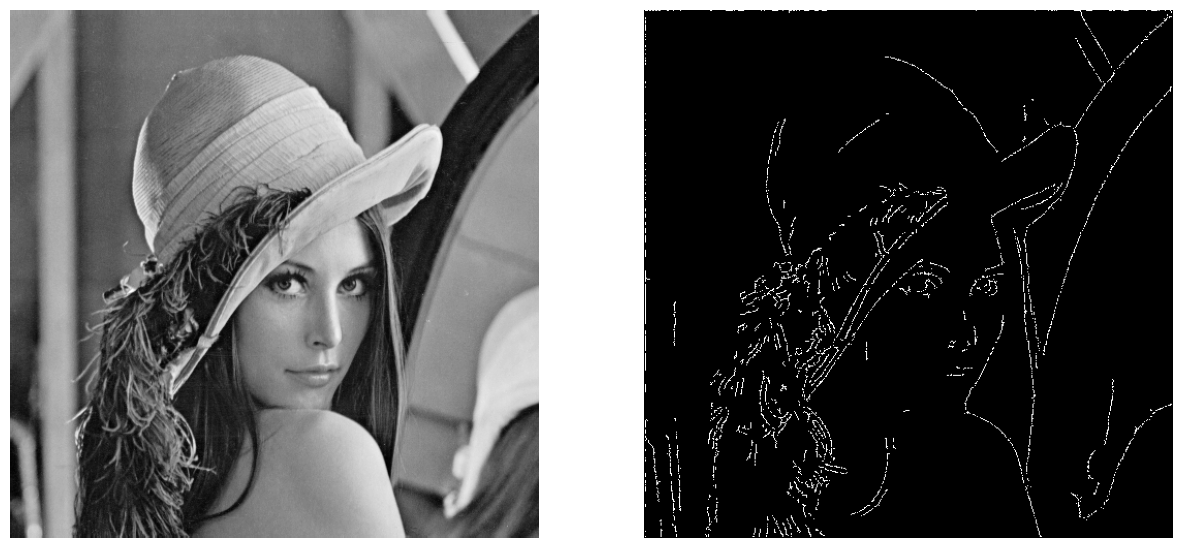

In [27]:
import matplotlib.pyplot as plt
global grayImage
def displayImage():
    image = cannyOperator()  # Get processed edge-detected image
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1) 
    plt.imshow(grayImage, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2) 
    plt.imshow(image, cmap='gray')
    plt.axis('off')

displayImage()